# Lab A: Qiskit Primitives and the QFT circuit

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [2]:
%pip install qiskit==1.2.4
%pip install qiskit-ibm-runtime==0.30.0
%pip install qiskit-aer==0.15.1

%pip install matplotlib
%pip install pylatexenc

from IPython.display import clear_output
clear_output()

In [3]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService
from qiskit_aer import AerSimulator, Aer

import numpy as np

## Qiskit Primitives

### Exercise 0: create the example circuit in the figure
https://drive.google.com/file/d/1dW_z9oCSSoSSm4ZYOvyKPg_TxtHFESuy/view?usp=sharing

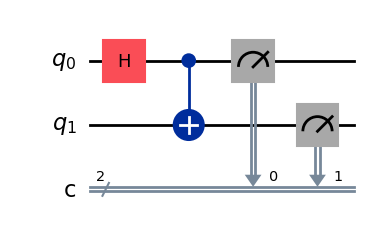

In [ ]:
bell =  # create a quantum circuit with 2 qubits and 2 classical bits

bell    # apply an H gate to the circuit
bell    # apply a CNOT gate to the circuit

bell    # measure the qubits

bell    # draw the resulting circuit


### Qiskit Primitives for simulations and runs on real hardware

In [7]:
simulation = True

if simulation:
    backend = AerSimulator()
    # You can use a fixed seed to get fixed results (error if run on quantum hardware).
    options = {"simulator": {"seed_simulator": 42}}
else:
    service = QiskitRuntimeService(channel='ibm_quantum', token="6bf37a1b8654227fbf579288a9beec760ffa3b075ae539e5e553cd69cf5e2446c5962d771f622171f5634cf5de119a63e6652a40bed5d80cd598430283e8c221")
    backend = service.least_busy(operational=True)
    options = {"default_shots": 1024}

    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    bell = pm.run(bell)


sampler = SamplerV2(mode=backend, options=options)

job = sampler.run([bell])

In [8]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

while job.status() in ['QUEUED', 'RUNNING']:
    if job.status() == 'QUEUED':
        continue
    elif job.status() == 'RUNNING':
        print(f">>> Job Status: {job.status()}")
        break

>>> Job ID: 8b75f2aa-8bf0-42f5-ac80-b0569e1ba406
>>> Job Status: JobStatus.DONE


In [9]:
# job = service.job('cw5dc68xa9wg0087w6n0')
result = job.result()
print(result)
print(result[0].data.c.get_counts())

PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})
{'00': 521, '11': 503}


## Quantum Fourier Transform

The quantum Fourier transform acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} a_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} b_k \vert k \rangle$ according to the formula


$$b_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}a_j\omega_N^{jk}$$


where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$. Note that only the amplitudes of the state were affected by this transformation.

For a given state $\vert j \rangle$, this can also be expressed as the map:


$$\vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$

Remember the quantum Fourier transform look like for a generic $N$. Again, $N=2^n$ and $QFT_N$ acts on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit.
$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$


### The Circuit that Implements the QFT <a name="circuit"></a>

The circuit that implements QFT makes use of two gates. The first one is a single-qubit Hadamard gate, $H$, that you already know. You have already seen that the action of $H$ on the single-qubit state $\vert x_k\rangle$ is



$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$



The second is a two-qubit controlled rotation $CROT_k$ given in block-diagonal form as

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$

where

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

The action of $CROT_k$ on a two-qubit state $\vert x_l x_j\rangle$ where the first qubit is the control and the second is the target is given by



$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$


and


$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$


The resulting circuit operates as follows. We start with an n-qubit input state $\vert x_1x_2\ldots x_n\rangle$.

1) After the first Hadamard gate on qubit 1, the state is transformed from the input state to

$$
H_1\vert x_1x_2\ldots x_n\rangle =
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

2) After the $UROT_2$ gate on qubit 1 controlled by qubit 2, the state is transformed to

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

3) After the application of the last $UROT_n$ gate on qubit 1 controlled by qubit $n$, the state becomes

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x_n +
\frac{2\pi i}{2^{n-1}}x_{n-1} +
\ldots +
\frac{2\pi i}{2^2}x_2 +
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

Noting that

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

we can write the above state as

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

4) After the application of a similar sequence of gates for qubits $2\ldots n$, we find the final state to be:

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^n}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{n-1}}x
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{2}}x
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle +
\exp\left(
\frac{2\pi i}{2^{1}}x
\right)
\vert1\rangle\right]
$$

which is exactly the QFT of the input state as derived above with the caveat that the order of the qubits is reversed in the output state.
</ol>

### Qiskit Implementation<a id='implementation'></a>

In Qiskit, the implementation of the $CROT$ gate used in the discussion above is a controlled phase rotation gate. This gate is defined in [OpenQASM](https://github.com/QISKit/openqasm) as

$$
CP(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$

Hence, the mapping from the $CROT_k$ gate in the discussion above into the $CP$ gate is found from the equation

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### Exercise 1: build the QFT on 2 Qubits <a id="threeqft"></a>

**Note**: Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored in relation to the image!

In [ ]:
qft_example = QuantumCircuit(2)

##############################
# add gates to your circuit here



##############################

qft_example.draw(output='mpl')

### Exercise 2: build the QFT on 3 qubits

https://drive.google.com/file/d/1oN7ZdFCNRsHTzzYnNPiANykgbbjhRt5o/view?usp=sharing

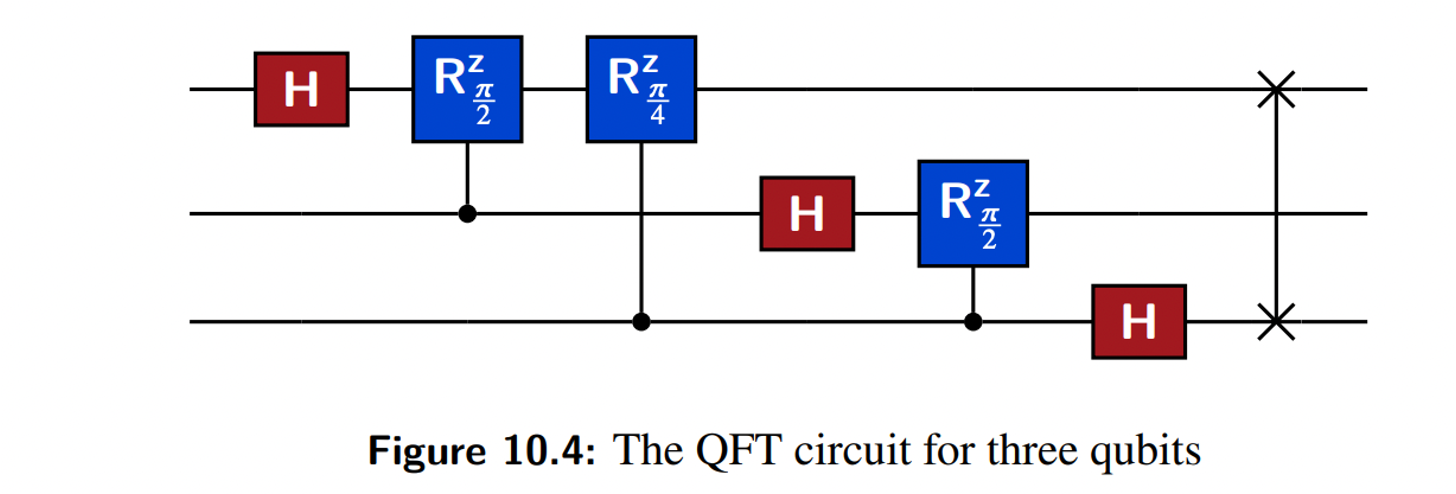


It is useful to work out the relevant code for the 3-qubit case before generalizing to the $n$-qubit case. First, we must define our quantum circuit:


In [11]:
# Define the quantum circuit


**Note again**: Remember that Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored in relation to the image.

In [ ]:
# Apply the first Hadamard on qubit 2


Next, we want to turn this an extra quarter turn if qubit 1 is in the state $|1\rangle$:

In [17]:
# CROT from qubit 1 to qubit 2


And another eighth turn if the least significant qubit (0) is $|1\rangle$:

In [18]:
# CROT from qubit 2 to qubit 0


With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

In [19]:
# Repeat the process for qubits 0 and 1


Finally we must swap the qubits 0 and 2 to complete the QFT:

In [ ]:
# Swap the qubits

# Draw the resulting circuit

### Exercise 3: General QFT Function

Create a general circuit for the QFT using basic Qiskit instructions.

It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards;

Hint: start off by creating the function that rotates your qubits correctly. Start as you did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index). This is the first part of the QFT. Now you need to correctly rotate the second most significant qubit. Then you must deal with the third most significant, and so on. But why write more code? When we get to the end of our `qft_rotations()` function, we can use the same code to repeat the process on the next `n-1` qubits

In [ ]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    ##############################
    # implement the function here



    ##############################
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    ##############################
    # implement the function here



    ##############################
    return circuit

def qft(circuit, n):
    ##############################
    # implement the function here



    ##############################
    return circuit

We now want to demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. We can see the number 5 in binary is `101`:

In [21]:
bin(5)

'0b101'

(The `0b` just reminds us this is a binary number).

### Exercise 4: Let's encode the number 5 into our qubits

In [22]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5




And let's check the qubit's states using the aer simulator:

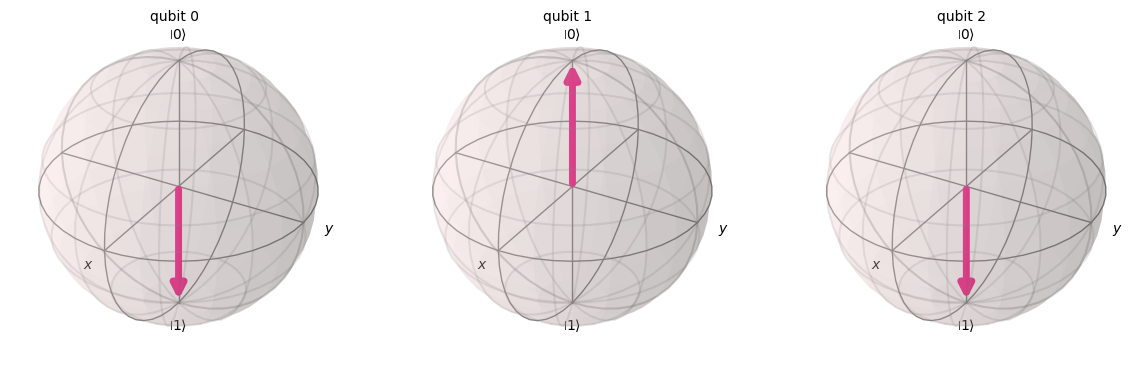

In [ ]:
sim = Aer.get_backend("aer_simulator")

qc_copy = qc.copy()
qc_copy.save_statevector()

statevector = sim.run(qc_copy).result().get_statevector()
plot_bloch_multivector(statevector)

Finally, let's use our QFT function and view the final state of our qubits:

In [ ]:
qft(qc,3)
qc.draw('mpl')

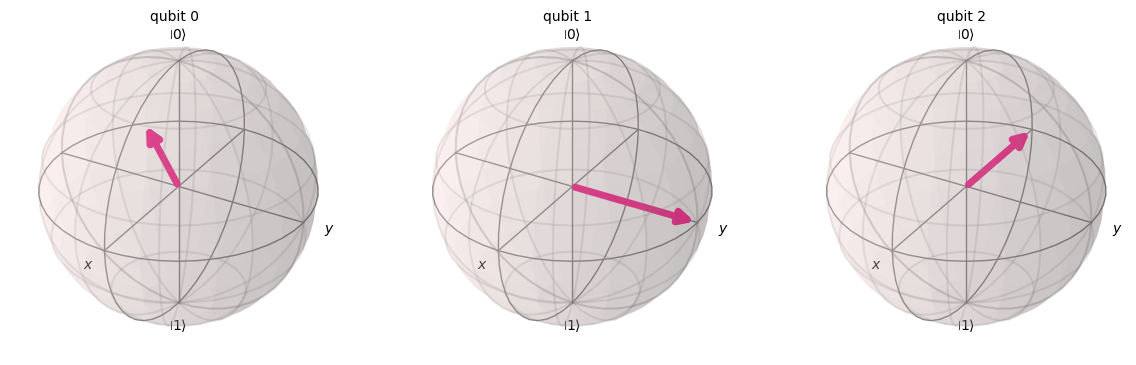

In [ ]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

You can now see if your QFT function has worked correctly. Compared to the state $|\widetilde{0}\rangle = |{+}{+}{+}\rangle$, Qubit 0 should have been rotated by $\tfrac{5}{8}$ of a full turn, qubit 1 by $\tfrac{10}{8}$ full turns (equivalent to $\tfrac{1}{4}$ of a full turn), and qubit 2 by $\tfrac{20}{8}$ full turns (equivalent to $\tfrac{1}{2}$ of a full turn).

### Exercise 5: verify QFT without computing the statevector

If we tried running the circuit above on a real device, the results would be completely random, since all qubits are in equal superposition of $|0\rangle$ and $|1\rangle$. How can we demonstrate and investigate the QFT working on real hardware?

Hint: the starting point should be to put our qubits in the state represented by the image above (the state $|\widetilde{5}\rangle$)

In [ ]:
# Create a circuit to verify the correctness of your QFT implementation without computing the StateVector



Now test the resulting circuit on real quantum hardware

In [ ]:
# Use Qiskit primitives to run the circuit on real HW

